In [116]:
import numpy as np
import tensorflow as tf
import pandas as pd
import keras_tuner as kt
from sklearn.model_selection import train_test_split

In [117]:
# setting the constants
SHUFFLE_BUFFER = 500
BATCH_SIZE = 2
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

##### Utility functions

In [118]:
def input_mix_dtypes(df, binary_feature_names=[], categorical_feature_names=[]):
    '''
    It returns dictionary of tensors. It creates the "placeholder" for 
    input tensor from DataFrame.
    '''
    inputs = {}
    for name, column in df.items():
        # setting the right dtype
        if type(column[0]) == str:
            dtype = tf.string
        elif (name in categorical_feature_names or
                name in binary_feature_names):
            dtype = tf.int64 # categorical integer
        else:
            dtype = tf.float32
        inputs[name] = tf.keras.Input(
            shape=(), # scalar input
            name=name, 
            dtype=dtype 
        )
    return inputs

In [119]:
def binary_preprocessor(preprocessed_list, inputs, binary_feature_names):
    '''
    It appends the binary preprocessors tensors to list of preprocessors. No transformation
    performed other than adding a new axia and casting
    '''
    for name in binary_feature_names:
        inp_bin = inputs[name]
        inp_bin_nw_axis = inp_bin[:, tf.newaxis]
        inp_bin_float = tf.cast(inp_bin_nw_axis, tf.float32)
        preprocessed_list.append(inp_bin_float) #the tensor, not the input dict
    return None

In [120]:
# numeric processing
def stack_dict(dict, function=tf.stack):
    '''
    take a dict of pd.Series or a dict of tensors and turns it into a tensor. Used for
    formating the input for adapt operation.
    '''
    values = [] #list of tensors
    for key in sorted(dict.keys()):
        # sort to ensure later matching to preserve order
        input_float = tf.cast(dict[key], tf.float32) 
        values.append(input_float)
    tensor_stacked = function( # stacks the list of tensors into a single one
                    values,
                    axis=-1 # last axis direction, in this case 1?
                    ) 
    return tensor_stacked

def numeric_preprocessor(df_adapter, stack_dict, preprocessed_list, inputs, numeric_feature_names):
    '''
    It appends the numeric preprocessor tensor to list of preprocessors. Normalization layer
    is used for trasnformation. 
    '''
    # adapting the normalizer
    df_adapter = df_adapter[numeric_feature_names]
    normalizer = tf.keras.layers.Normalization(axis=-1)
    tensor_dfcolumns = stack_dict(dict(df_adapter))
    normalizer.adapt(tensor_dfcolumns) # equivalent to fit

    #input for numeric only
    inputs_numeric = {}
    for name in numeric_feature_names:
        inputs_numeric[name] = inputs[name]

    tensor_numeric_inputs = stack_dict(inputs_numeric)
    numeric_normalized = normalizer(tensor_numeric_inputs) # similar to transform

    preprocessed_list.append(numeric_normalized)
    return None

In [121]:
# categorical processing
def categorical_preprocessor(df_adapter, preprocessed_list, inputs, categorical_feature_names):
    '''
    It appends the categorical preprocessors tensors to list of preprocessors. It adds a 
    a new axis to each input tensor and then adds a lookup layer.
    '''
    for name in categorical_feature_names:
        vocab = sorted(set(df_adapter[name]))

        # create lookup layers
        if type(vocab[0]) is str:
            lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
        else:
            lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')
        
        input = inputs[name][:,tf.newaxis] # for compatibility
        one_hot_tensor = lookup(input)
        preprocessed_list.append(one_hot_tensor)
    return None

In [122]:
def preprocessor_model(numeric_feature_names,
                       binary_feature_names, 
                       categorical_feature_names,
                       X_train,
                       df, #consider all categories
                       inputs
                       ):
    '''
    It returns the preprocessor model. Take the names of inputs for preserving order
    '''
    preprocessed_list = [] # list of input, preprocessed tensors

    binary_preprocessor(preprocessed_list, inputs, binary_feature_names)
    numeric_preprocessor(X_train,  stack_dict, preprocessed_list, inputs, numeric_feature_names)
    categorical_preprocessor(df, preprocessed_list, inputs, categorical_feature_names)

    preprocessed_result = tf.concat(preprocessed_list, axis=-1) # preprocessed tensor

    # creating the preprocessing model
    preprocessor = tf.keras.Model(inputs, preprocessed_result)
    return preprocessor

#### Model building

In [131]:
# importing and splitting
data_path = '../data/real_state_data_for_model.csv'
df = pd.read_csv(data_path)
#df.columns
df.isna().sum()

precio                 0
ambientes            773
no_baños               0
terreno_m2             0
año_constr             0
no_dormitorios         0
area_constr_m2         0
estacionamientos       0
latitud                0
longitud               0
tipo_de_propiedad      0
ciudad                 0
zona                   0
dtype: int64

In [128]:
#separando la variable objetivo
X = df.drop('precio', axis=1)
y = df['precio']
y_stratify = df[['tipo_de_propiedad']] #mantener las proporciones de tipo_de_propiedad

# preprocesando los datos
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.25, 
    random_state=RANDOM_SEED,
    stratify=y_stratify
)

# variables para las transformaciones, 
numeric_feature_names = ['no_baños', 'terreno_m2', 'año_constr',
       'no_dormitorios', 'area_constr_m2', 'latitud', 'longitud', 'estacionamientos']
categorical_feature_names = ['tipo_de_propiedad', 'ciudad', 'zona']
binary_feature_names = []

In [129]:
# create dict of input tensors 
inputs = input_mix_dtypes(X_train, binary_feature_names, categorical_feature_names)

# create preprocessor
preprocessor = preprocessor_model(
    numeric_feature_names, 
    binary_feature_names, 
    categorical_feature_names,
    X_train,
    X,
    inputs
)


In [130]:
# baseline model
body = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

preprocessed_tensor = preprocessor(inputs)
result_tensor = body(preprocessed_tensor)
model = tf.keras.Model(inputs, result_tensor)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(name='mean_squared_error'),
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
        tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
        tf.keras.metrics.MeanAbsolutePercentageError(name="mean_absolute_percentage_error")
    ]
)

model.fit(dict(X_train), y_train, epochs=5, batch_size=BATCH_SIZE, verbose=1)

print(model.evaluate(dict(X_test),  y_test, verbose=2))

Epoch 1/5
542/542 [==============================] - 3s 6ms/step - loss: 9910731776.0000 - mean_absolute_error: 95384.6094 - root_mean_squared_error: 99552.6562 - mean_absolute_percentage_error: 99.9836
Epoch 2/5
542/542 [==============================] - 3s 5ms/step - loss: 9854343168.0000 - mean_absolute_error: 95084.6797 - root_mean_squared_error: 99269.0469 - mean_absolute_percentage_error: 99.6268
Epoch 3/5
542/542 [==============================] - 3s 5ms/step - loss: 9633567744.0000 - mean_absolute_error: 93910.6953 - root_mean_squared_error: 98150.7422 - mean_absolute_percentage_error: 98.2368
Epoch 4/5
542/542 [==============================] - 3s 6ms/step - loss: 9168562176.0000 - mean_absolute_error: 91442.9453 - root_mean_squared_error: 95752.6094 - mean_absolute_percentage_error: 95.3876
Epoch 5/5
542/542 [==============================] - 3s 6ms/step - loss: 8449837056.0000 - mean_absolute_error: 87482.0312 - root_mean_squared_error: 91922.9922 - mean_absolute_percentage_

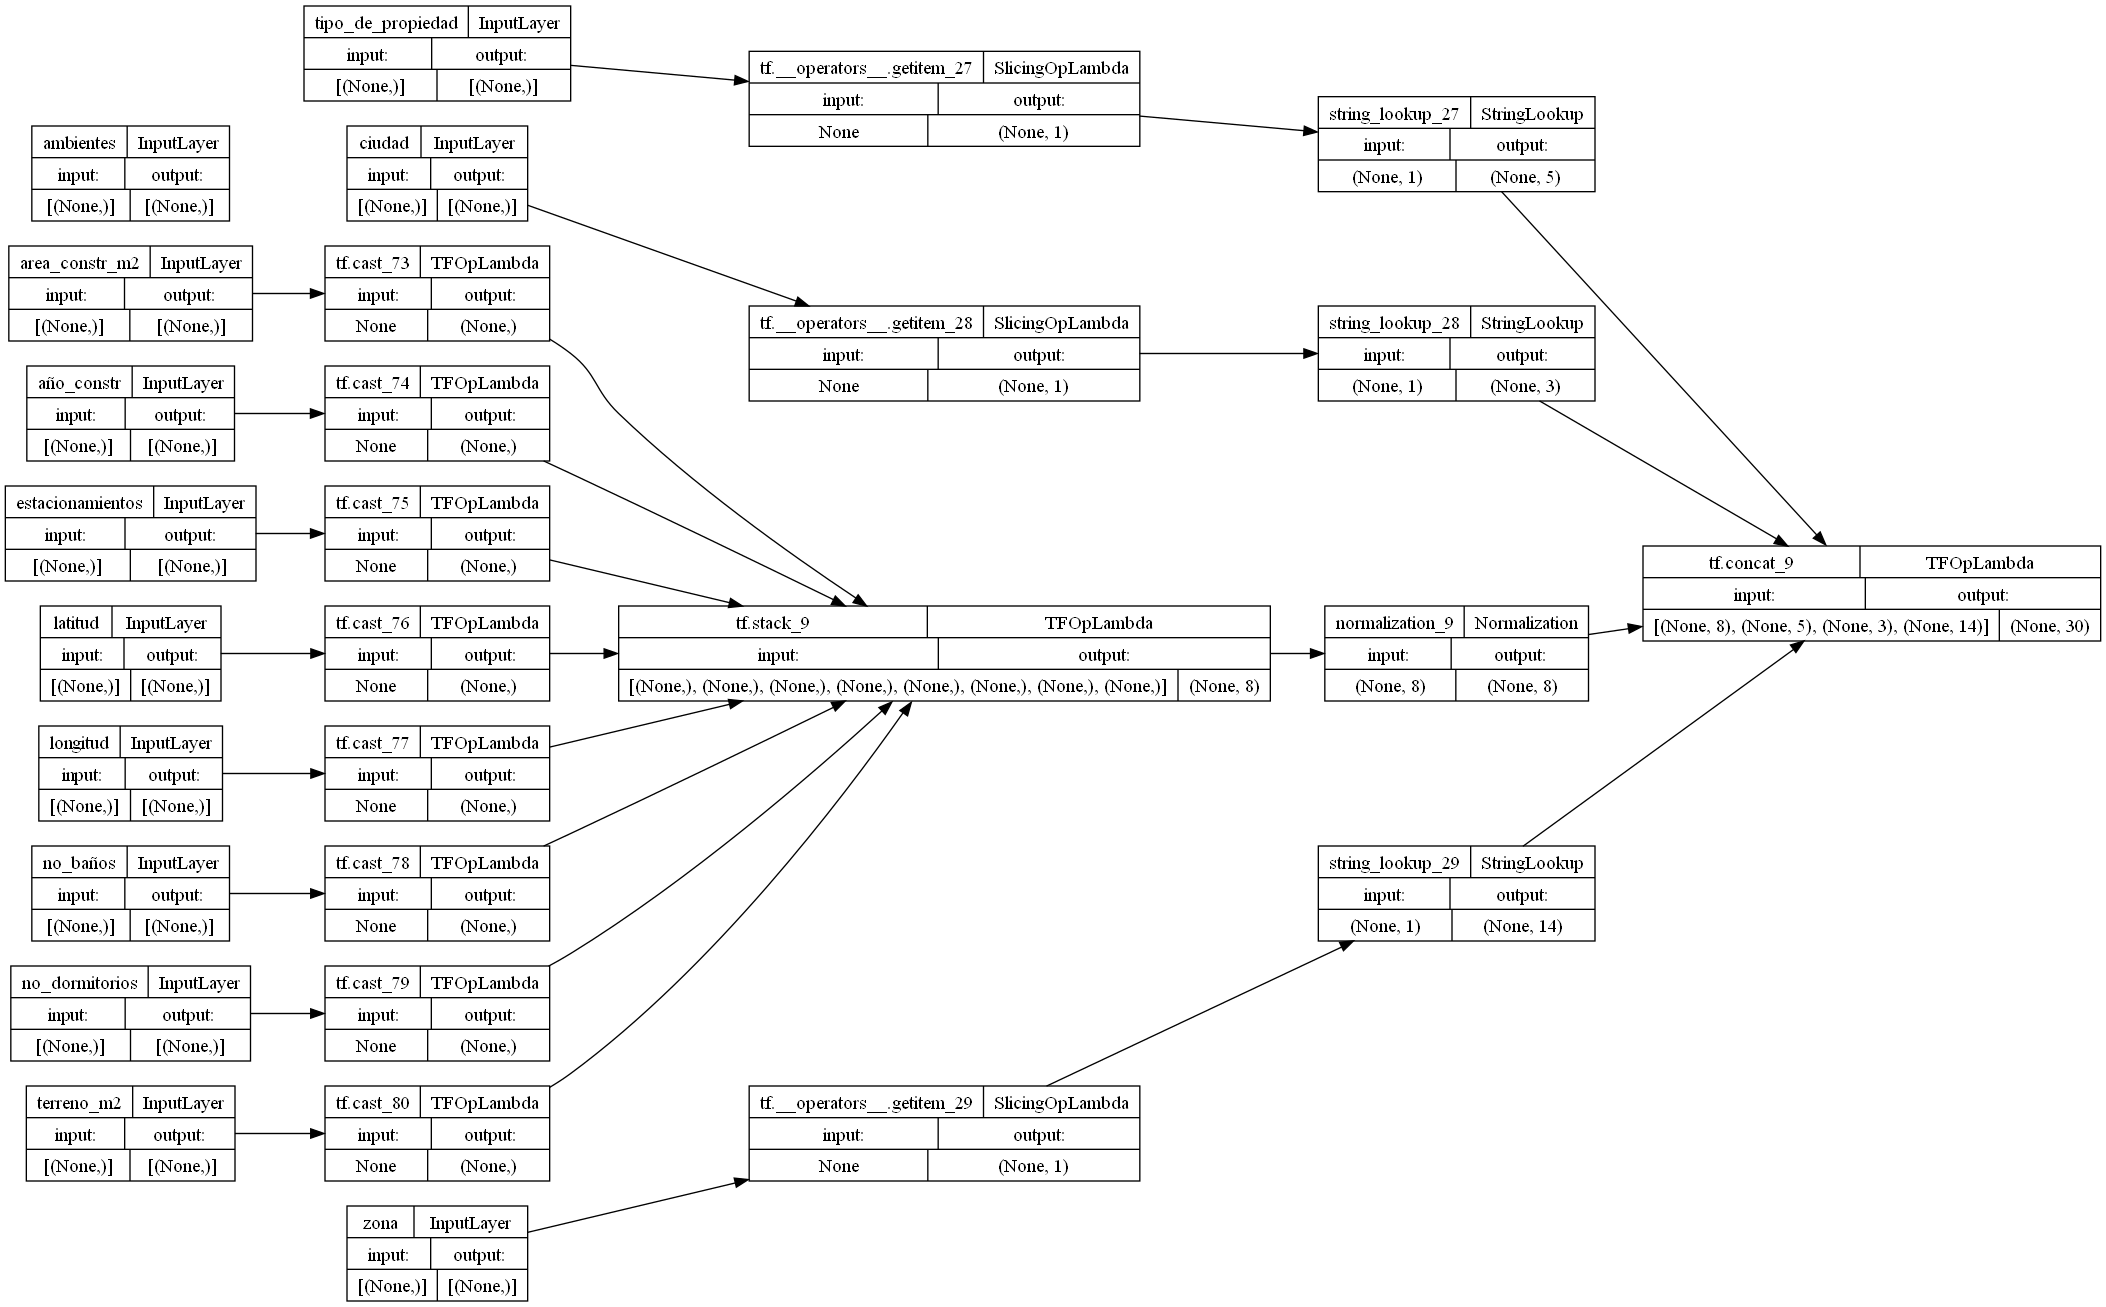

In [132]:
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

#### Hiperparameter tuning

In [134]:
def compiled_model(hp,
                   learning_rate,
                   layers,
                   activation): # if X_train, preprocessor and inputs are in memory it works

    # building the body
    body = tf.keras.Sequential()
    for i in range(layers):
        neurons = hp.Int(f"units_{i}", min_value=5, max_value=250, step=5)
        body.add(tf.keras.layers.Dense(neurons, activation=activation))
    body.add(tf.keras.layers.Dense(1))

    # building the final model
    preprocessed_tensor = preprocessor(inputs)
    result_tensor = body(preprocessed_tensor)
    model = tf.keras.Model(inputs, result_tensor)

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(name='mean_squared_error'),
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
            tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
            tf.keras.metrics.MeanAbsolutePercentageError(name="mean_absolute_percentage_error"),
            #tf.keras.metrics.Metric(r2_metric, name='r2_score')
        ]
    )
    return model

def build_model(hp):
    activation = hp.Choice("activation", ["relu", "tanh", "selu"])
    layers = hp.Int("layers", min_value=1, max_value=10, step=1)
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    dropout = hp.Boolean("dropout")

    # call existing model-building code with the hyperparameter values.
    model = compiled_model(hp, learning_rate, layers, activation)
    return model


tuner = kt.Hyperband(
                     build_model,
                     objective= kt.Objective("root_mean_squared_error", direction="min"),
                     max_epochs=50,
                     factor=10,
                     directory='my_dir',
                     project_name='intro_to_kt',
                     overwrite=True
                     )

tuner.search(dict(X_train), y_train, epochs=5, validation_data=(dict(X_test), y_test))

best_model = tuner.get_best_models()[0]
print('\n ', best_model.evaluate(dict(X_test),  y_test, verbose=2))
print('\n ', best_model.evaluate(dict(X_train),  y_train, verbose=2))

Trial 20 Complete [00h 00m 15s]
root_mean_squared_error: 97617.21875

Best root_mean_squared_error So Far: 15576.1806640625
Total elapsed time: 00h 02m 02s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


12/12 - 0s - loss: 303269024.0000 - mean_absolute_error: 12478.9629 - root_mean_squared_error: 17414.6211 - mean_absolute_percentage_error: 16.5347 - 209ms/epoch - 17ms/step

  [303269024.0, 12478.962890625, 17414.62109375, 16.534696578979492]
34/34 - 0s - loss: 235014512.0000 - mean_absolute_error: 11248.9355 - root_mean_squared_error: 15330.1826 - mean_absolute_percentage_error: 14.1440 - 148ms/epoch - 4ms/step

  [235014512.0, 11248.935546875, 15330.1826171875, 14.144047737121582]


#### Exporting the model

In [ ]:
# exporting and importing the model
print(best_model.predict(dict(X_train.iloc[:1])))
best_model.save('model')
model_1 = tf.keras.models.load_model('model')
print(model_1.predict(dict(X_train.iloc[:1])))

#### Debugging

In [81]:
data = {
    'ambientes': [7],
    'no_baños': [2],
    'terreno_m2': [393],
    'año_constr': [2013],
    'no_dormitorios': [3],
    'area_constr_m2': [100.0],
    'estacionamientos': [4],
    'latitud': [-17.643187],
    'longitud': [-63.173777],
    'tipo_de_propiedad': ['Casa'],
    'ciudad': ['Santa Cruz de la Sierra'],
    'zona': ['Norte']
}
#imput_data: dataframe
data_1 = pd.DataFrame(data)
print(model.predict(dict(data_1)))


1/1 [==============================] - 0s 113ms/step
[[nan]]


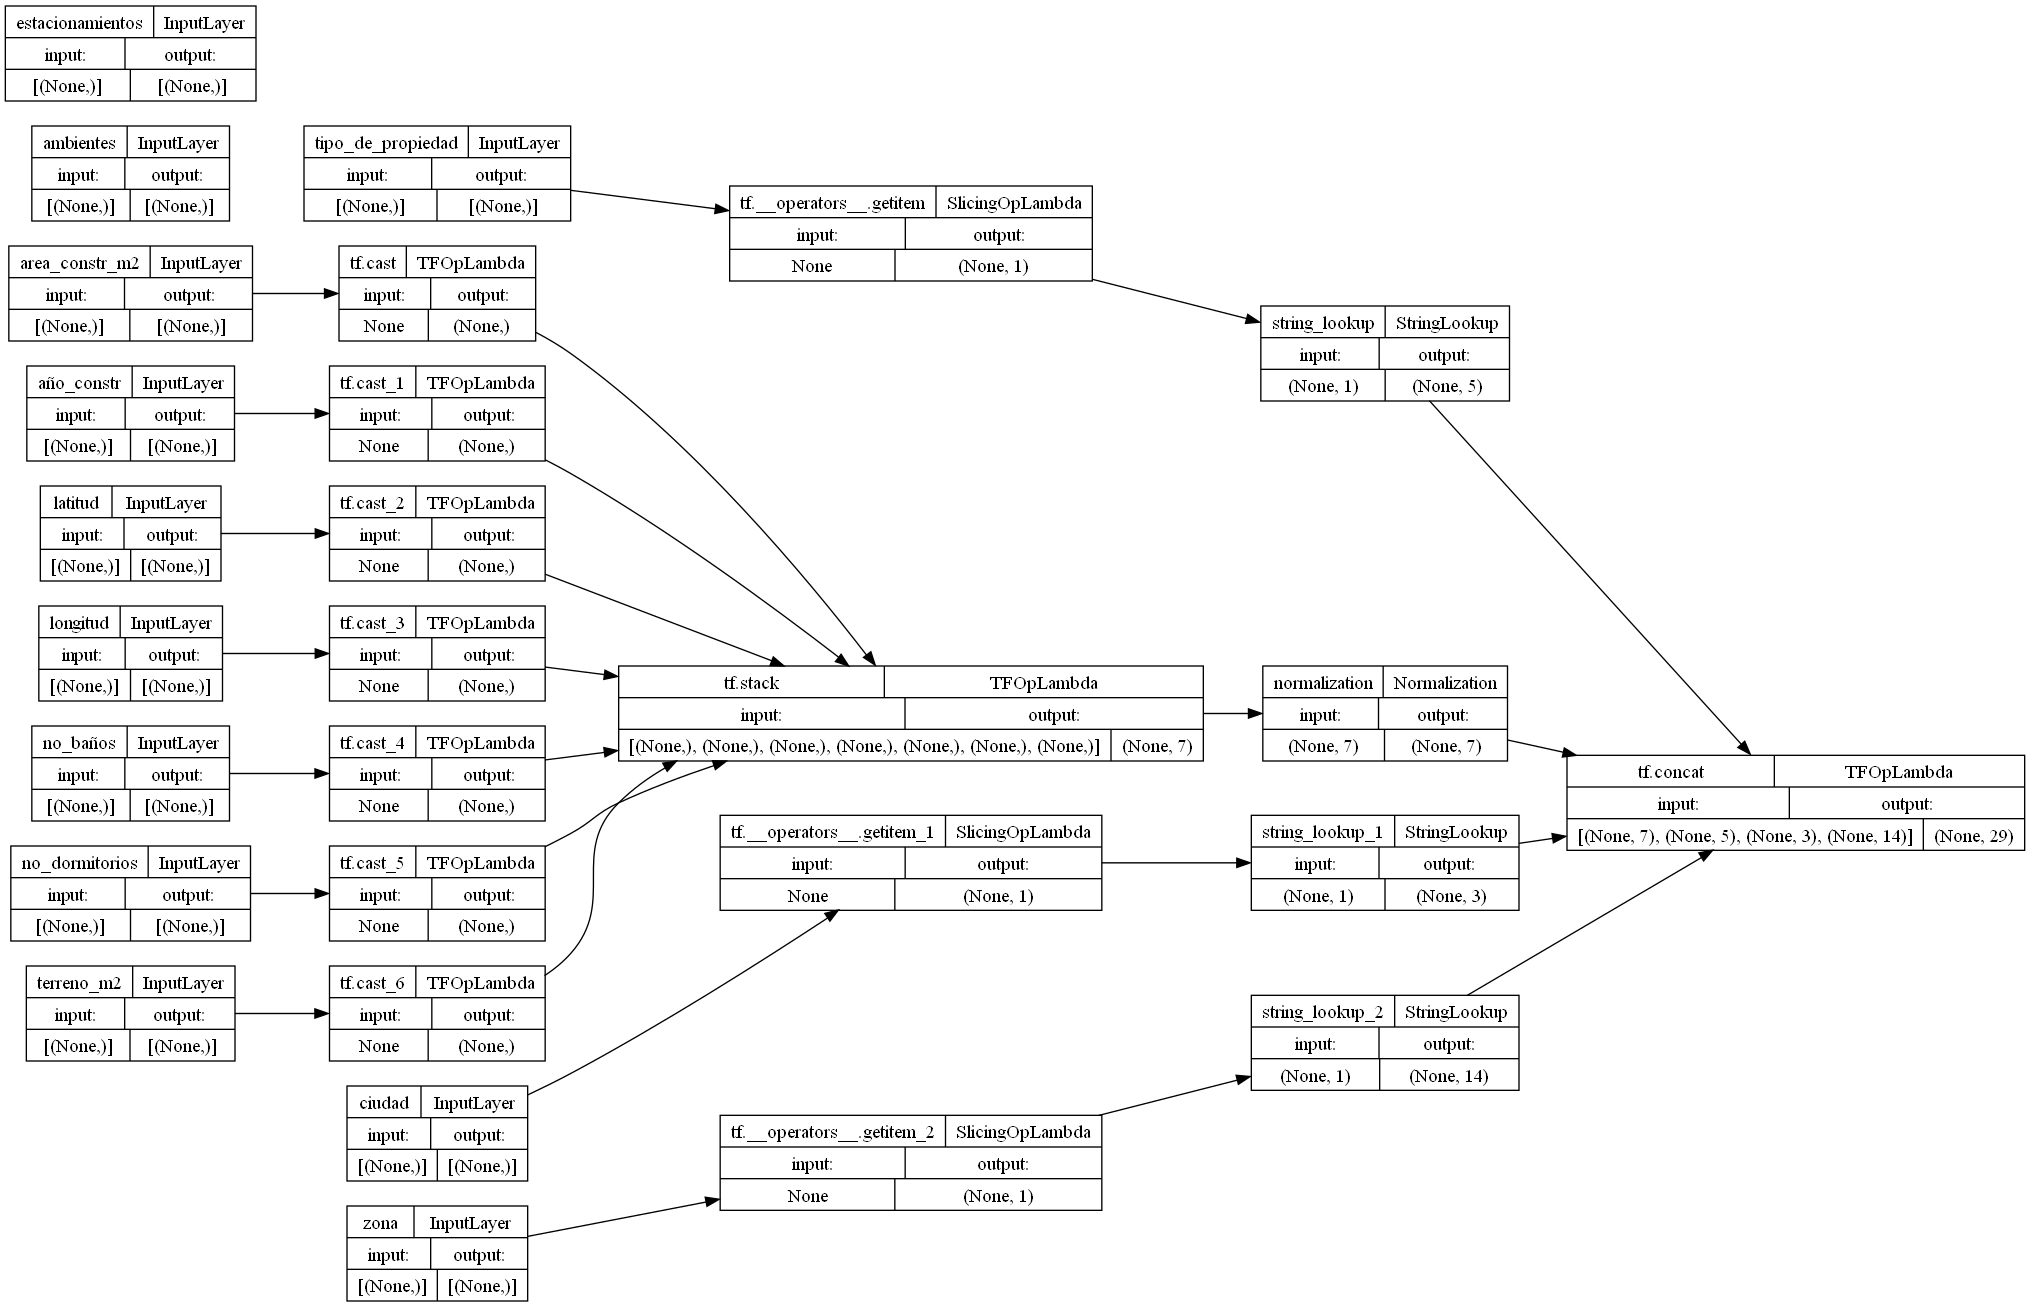

In [51]:
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)